<h3> Backtesting </h3>

The primary goal of this notebook is to backtest the GARCH(1,1) model using SPX data. We will apply the model to test various market neutral  option strategies:

- **Straddle**: A strategy involving buying or selling a call option and a put option with the same strike price and expiration date.
- **Strangle**: A strategy where one buys or sells a call option and a put option with different strike prices, but with the same expiration date.
- **Butterfly**: A neutral option strategy combining bull and bear spreads, where an investor will buy (or sell) two identical in-the-money options, simultaneously selling (or buying) an out-of-the-money option and an at-the-money option. This strategy aims to capitalize on minimal price movement.
- **Condor**: A neutral strategy combining both bull and bear spreads.

Through this backtesting, we aim to understand the effectiveness of the GARCH(1,1) as well as stochastic volatility model in predicting volatility for these option strategies and to identify which combinations provide the best returns with managed risk.


<h4> 1.0 Importing necessary packages and loading data</h4>

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from matplotlib import pyplot as plt
from src.data_handling import load_csv_data


# -- Importing and pre-processing data
DATA_PATH = 'DATA/processed/df.csv'
df = load_csv_data(DATA_PATH)
df["IRX_Close"] = df["IRX_Close"].apply(abs)
df.head()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,...,VIX_Open,VIX_High,VIX_Low,VIX_Close,VIX_Adj Close,IRX_Open,IRX_High,IRX_Low,IRX_Close,IRX_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.531765,212818400.0,15.6290,15.7375,15.3480,15.4260,...,17.760000,20.139999,17.049999,17.790001,17.790001,0.030,0.030,0.015,0.015,0.015
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.840672,257142000.0,15.3505,15.4190,15.0425,15.1095,...,19.190001,21.290001,19.190001,19.920000,19.920000,0.008,0.018,0.003,0.003,0.003
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.842909,263188400.0,15.1120,15.1500,14.6190,14.7645,...,20.330000,22.900000,19.520000,21.120001,21.120001,0.023,0.023,0.018,0.020,0.020
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.177242,160423600.0,14.8750,15.0640,14.7665,14.9210,...,20.150000,20.719999,19.040001,19.309999,19.309999,0.023,0.025,0.020,0.020,0.020
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.106180,237458000.0,15.0160,15.1570,14.8055,15.0230,...,17.930000,18.090000,16.990000,17.010000,17.010000,0.020,0.020,0.015,0.018,0.018


<h4> 2.0 Defining volatility forecasting function with GARCH and stochastic volatility </h4>

Defining volatililty forecasting function

In [2]:
from src.vol_forecasting import GARCHVolForecast, StochasticVolForecast
from arch import arch_model

def stochastic_volatility(data, n_days, n_sim = 1000):
    """
    Translating StochasticVolForecast class into a single function
    """
    stochVolForecast = StochasticVolForecast(data)
    stochVolForecast.fit_model()
    vol = stochVolForecast.forecast_volatility(n_days, n_sim)


    return vol

def garch_volatility(data, n_days):
    """
    Translating GARCHVolForecast class into a single function
    """
    GARCH_model = GARCHVolForecast(data)
    GARCH_model.fit_model()
    vol = GARCH_model.forecast_volatility(n_days)

    return vol

<h4> 2.1 Choose model to backtest </h4>

Select the forecasting model to beused, either 'GARCH', 'StochVol' or 'mix'

In [3]:
FORECASTING_MODEL = 'mix'

def forecast_volatility(data, n_days):
    if FORECASTING_MODEL == 'GARCH':
        return garch_volatility(data, n_days)
    elif FORECASTING_MODEL == 'StochVol':
        return stochastic_volatility(data, n_days)
    elif FORECASTING_MODEL == 'mix':
        garch_vol = garch_volatility(data[-5:], n_days)
        stoch_vol = stochastic_volatility(data, n_days)

        return 0.5 * (garch_vol + stoch_vol)



<h4>3.0 Defining strategies </h4>

In this section, we define functions for generating various options trading strategies. The functions encompass strategies such as:

- Straddle Strategy
- Strangle Strategy
- Butterfly Strategy
- Condor Strategy
  
Each function takes historical prices, forecasted volatility, and a confidence level as input parameters, along with some optional arguments. Depending on specific conditions, these functions will either return None to indicate that no trades should be executed or return an OptionCombination object, suggesting that a particular trade should be executed.

In [4]:
from src.options import Option, OptionCombination, Straddle, Strangle, Butterfly, Condor

def straddle_strategy(df, forecasted_vol, confidence, long_short='short', T=7/365):
    straddle = Straddle(S=df['SPX_Close'].iloc[-1],
                        K=df['SPX_Close'].iloc[-1],
                        T=T,
                        r=df['IRX_Close'].iloc[-1],
                        sigma=df['VIX_Close'].iloc[-1]/100,
                        long_short=long_short)

    break_even_prices = straddle.break_even_prices()
    forecast_break_even = (df['SPX_Close'].iloc[-1] - forecasted_vol * confidence, 
                           df['SPX_Close'].iloc[-1] + forecasted_vol * confidence)
    if forecast_break_even[0] < break_even_prices[0] or forecast_break_even[1] > break_even_prices[1]:
        return None
    else:
        return straddle

def strangle_strategy(df, forecasted_vol, confidence, long_short='short', T=7/365):
    strangle = strangle = Strangle(S=df['SPX_Close'].iloc[-1],
                                   K_low=df['SPX_Close'].iloc[-1] - confidence * forecasted_vol, 
                                   K_high=df['SPX_Close'].iloc[-1] + confidence * forecasted_vol, 
                                   T=T,
                                   r=df['IRX_Close'].iloc[-1], 
                                   sigma=df['VIX_Close'].iloc[-1]/100,
                                   long_short=long_short)

    return strangle

def butterfly_strategy(df, forecasted_vol, confidence, long_short='long', T=7/365):
    butterfly = Butterfly(S=df['SPX_Close'].iloc[-1],
                           K_low=df['SPX_Close'].iloc[-1] - forecasted_vol * confidence,
                           K_mid=df['SPX_Close'].iloc[-1],
                           K_high=df['SPX_Close'].iloc[-1] + forecasted_vol * confidence, 
                           T=T,
                           r=df['IRX_Close'].iloc[-1],
                           sigma=df['VIX_Close'].iloc[-1]/100,
                           long_short=long_short)
    return butterfly

def condor_strategy(df, forecasted_vol, confidence_1, confidence_2=1, long_short='long', T=7/365):
    condor = Condor(S=df['SPX_Close'].iloc[-1],
                           K1=df['SPX_Close'].iloc[-1] - forecasted_vol * (confidence_1+confidence_2),
                           K2=df['SPX_Close'].iloc[-1] - forecasted_vol * confidence_1,
                           K3=df['SPX_Close'].iloc[-1] + forecasted_vol * confidence_1, 
                           K4=df['SPX_Close'].iloc[-1] + forecasted_vol * (confidence_1+confidence_2),
                           T=T,
                           r=df['IRX_Close'].iloc[-1],
                           sigma=df['VIX_Close'].iloc[-1]/100,
                           long_short=long_short)
    return condor

<h4> 3.2 Risk Management (Stop-loss) </h4>

In [ ]:
def get_breakeven_exceed_index(option_combination: 'OptionCombination', prices: list) -> int:
    """
    Determine the index at which the price of the underlying asset exceeds the break-even-point 
    for the given option combination.

    Args:
    - option_combination (OptionCombination): The option combination object.
    - prices (List[Union[int, float]]): A list of prices of the underlying asset.

    Returns:
    - int: The index at which the price exceeds the break-even point. Returns length of prices if never exceeded.
    """
    
    # Fetch the break-even prices once, as they are constants for a given option_combination
    break_even_prices = option_combination.break_even_prices()
    
    for idx, price in enumerate(prices):

        if (break_even_prices[0]> price) or (break_even_prices[1]< price):
            return idx
        
    return idx
        


<h3> 4.0 Backtesting </h4>

In [ ]:
from src.back_testing import back_testing_strategy, sharpe_ratio
from src.black_scholes import annualized_volatility

<h4> 4.1 Backtesting strategies</h4>

In [ ]:
VOL_LOOKBACK = 35
CONFIDENCE = 1.96
HOLDING_PERIOD = 7/365
FORECAST_DAYS = 7

print('Backtesting Straddle...')
straddle_val, straddle_pnl, straddle_rf, straddle_dates = back_testing_strategy(df, straddle_strategy, 
                                                                                forecast_volatility,
                                                                                FORECAST_DAYS,
                                                                                stop_loss=get_breakeven_exceed_index,
                                                                                vol_lookback=VOL_LOOKBACK,
                                                                                confidence=CONFIDENCE,
                                                                                T=HOLDING_PERIOD)

print('Backtesting Strangle...')
strangle_val, strangle_pnl, strangle_rf, strangle_dates = back_testing_strategy(df,strangle_strategy, 
                                                                                forecast_volatility, 
                                                                                FORECAST_DAYS,
                                                                                stop_loss=get_breakeven_exceed_index,
                                                                                vol_lookback=VOL_LOOKBACK,
                                                                                confidence=CONFIDENCE,
                                                                                T=HOLDING_PERIOD)

print('Backtesting Butterfly...')
butterfly_val, butterfly_pnl, butterfly_rf, butterfly_dates = back_testing_strategy(df, butterfly_strategy, 
                                                                                    forecast_volatility, 
                                                                                    FORECAST_DAYS,
                                                                                    stop_loss=get_breakeven_exceed_index,
                                                                                    vol_lookback=VOL_LOOKBACK,
                                                                                    confidence=CONFIDENCE+1,
                                                                                    T=HOLDING_PERIOD)

print('Backtesting Condor...')
condor_val, condor_pnl, condor_rf, condor_dates = back_testing_strategy(df, condor_strategy, 
                                                                        forecast_volatility, 
                                                                        FORECAST_DAYS,
                                                                        stop_loss=get_breakeven_exceed_index,
                                                                        vol_lookback=VOL_LOOKBACK,
                                                                        confidence=CONFIDENCE,
                                                                        T=HOLDING_PERIOD)


Backtesting Straddle...


/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/st

Backtesting Strangle...


/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/st

Backtesting Butterfly...


/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:293: RuntimeWarning: invalid value encountered in log
  log_returns = np.log(simulated_prices[1:] / simulated_prices[:-1])
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/ana

Backtesting Condor...


/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/stoch_modelling.py:195: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
/home/bruce/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/bruce/Desktop/Imperial/Sem 3/AP/CODE/src/st

<h3> 5.0 Analysing results </h3>

In this section of the code, we will be analysing the results of each strategy. Going through their total PnL, Sharpe Ratio, as well as information ratio compared to holding SP500.

In [ ]:
from src.back_testing import sharpe_ratio, information_ratio

<h4> 5.1 ROI </h4>

In [ ]:
straddle_roi  = straddle_pnl / abs(straddle_val)
strangle_roi  = strangle_pnl / abs(strangle_val)
butterfly_roi = butterfly_pnl / abs(butterfly_val)
condor_roi    = condor_pnl / abs(condor_val)

# strangle_val, strangle_pnl   = strangle_val[strangle_roi > -10], strangle_pnl[strangle_roi > -10]
# strangle_rf, strangle_dates  = strangle_rf[strangle_roi > -10], strangle_dates[strangle_roi > -10]
# strangle_roi = strangle_roi[strangle_roi > -10]


<h4> 5.2 Average PnL (value and percentage) </h4>

In [ ]:
straddle_pnl_avg, strangle_pnl_avg = straddle_pnl.mean()*100, strangle_pnl.mean()*100
butterfly_pnl_avg, condor_pnl_avg = butterfly_pnl.mean()*100, condor_pnl.mean()*100

<h4> 5.1 Sharpe Ratio </h4>

Defining Sharpe Ratio function

In [ ]:
straddle_SR  = sharpe_ratio(straddle_pnl, straddle_rf)
strangle_SR  = sharpe_ratio(strangle_pnl, strangle_rf)
butterfly_SR = sharpe_ratio(butterfly_pnl, butterfly_rf)
condor_SR    = sharpe_ratio(condor_pnl, condor_rf)

<h4> 5.2 Information Ratio </h4>

In [ ]:
def compute_returns(price_series, dates, holding_period):
    holding_period_idx = (holding_period//7) * 5
    date_idx = [price_series.index.get_loc(date) for date in dates]

    return [(price_series.iloc[idx + 5 ] - price_series.iloc[idx]) / price_series.iloc[idx] for idx in date_idx]

straddle_spx  = compute_returns(df['SPX_Close'], straddle_dates, 7)
strangle_spx  = compute_returns(df['SPX_Close'], strangle_dates, 7)
butterfly_spx = compute_returns(df['SPX_Close'], butterfly_dates, 7)
condor_spx    = compute_returns(df['SPX_Close'], condor_dates, 7)

straddle_ir  = information_ratio(straddle_roi, straddle_spx)
strangle_ir  = information_ratio(strangle_roi, strangle_spx)
butterfly_ir = information_ratio(butterfly_roi, butterfly_spx)
condor_ir    = information_ratio(condor_roi, condor_spx)

In [ ]:
analysis = {'straddle' : [sum(straddle_pnl)*100, straddle_pnl_avg, sum(straddle_roi), straddle_roi.mean(), straddle_SR, straddle_ir],
            'strangle' : [sum(strangle_pnl)*100, strangle_pnl_avg, sum(strangle_roi), strangle_roi.mean(), strangle_SR, strangle_ir],
            'butterfly': [sum(butterfly_pnl)*100, butterfly_pnl_avg, sum(butterfly_roi), butterfly_roi.mean(), butterfly_SR, butterfly_ir],
            'condor'   : [sum(condor_pnl)*100, condor_pnl_avg, sum(condor_roi), condor_roi.mean(), condor_SR, condor_ir]}

analysis_df = pd.DataFrame.from_dict(analysis).T
analysis_df.columns = ['Total PnL', 'Average PnL', 'Total ROI', 'Average ROI', 'Sharpe Ratio', 'Information Ratio']

display(analysis_df)

,Total PnL,Average PnL,Total ROI,Average ROI,Sharpe Ratio,Information Ratio
straddle,3.292725e+06,8150.308868,289.304324,0.716100,1.108164,2.652692
strangle,3.326315e+06,7771.764513,386.656303,0.903403,1.070795,3.271616
butterfly,-1.233866e+05,-291.006105,-8458.485361,-19.949258,-0.322969,-0.082310
condor,-6.194488e+04,-145.752664,-8265.873364,-19.449114,-0.422949,-0.084248


<h4> 5.3 Visualisations </h4>

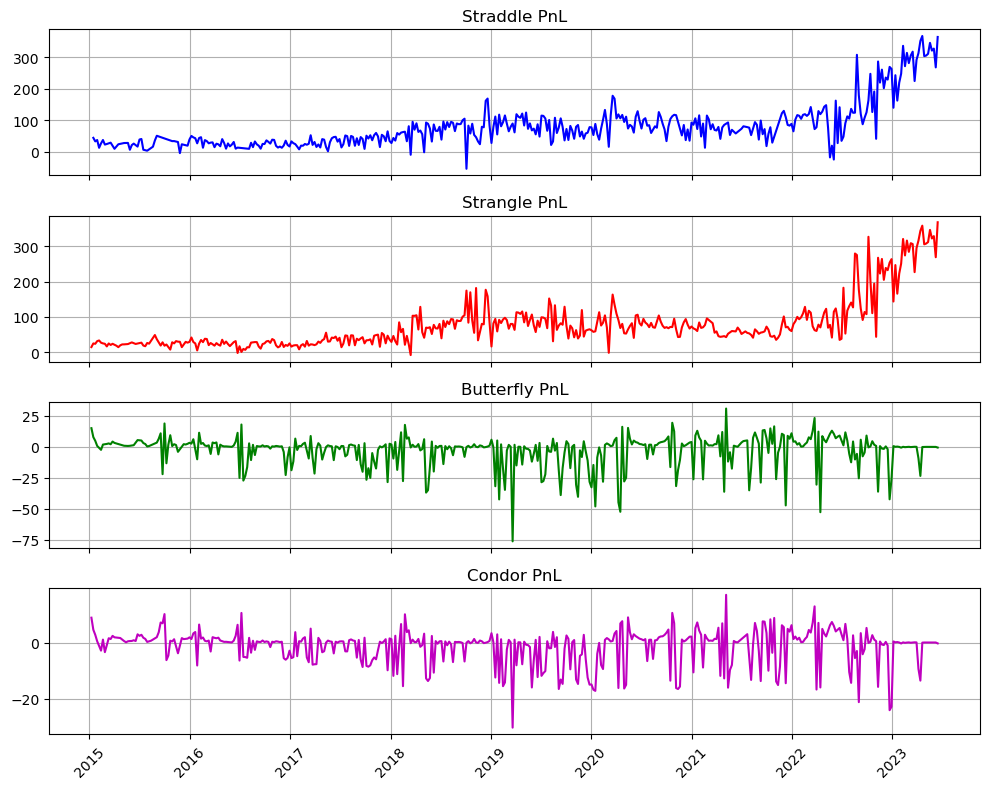

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot data for each strategy
axes[0].plot(straddle_dates, straddle_pnl, color='b', label='Straddle PnL')
axes[1].plot(strangle_dates, strangle_pnl, color='r', label='Strangle PnL')
axes[2].plot(butterfly_dates, butterfly_pnl, color='g', label='Butterfly PnL')
axes[3].plot(condor_dates, condor_pnl, color='m', label='Condor PnL')

# Add titles and legends
axes[0].set_title('Straddle PnL')
axes[1].set_title('Strangle PnL')
axes[2].set_title('Butterfly PnL')
axes[3].set_title('Condor PnL')

# Set grid to true
axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)
axes[3].grid(True)
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Adjust the layout
plt.tight_layout()
# Display the plot
plt.show()

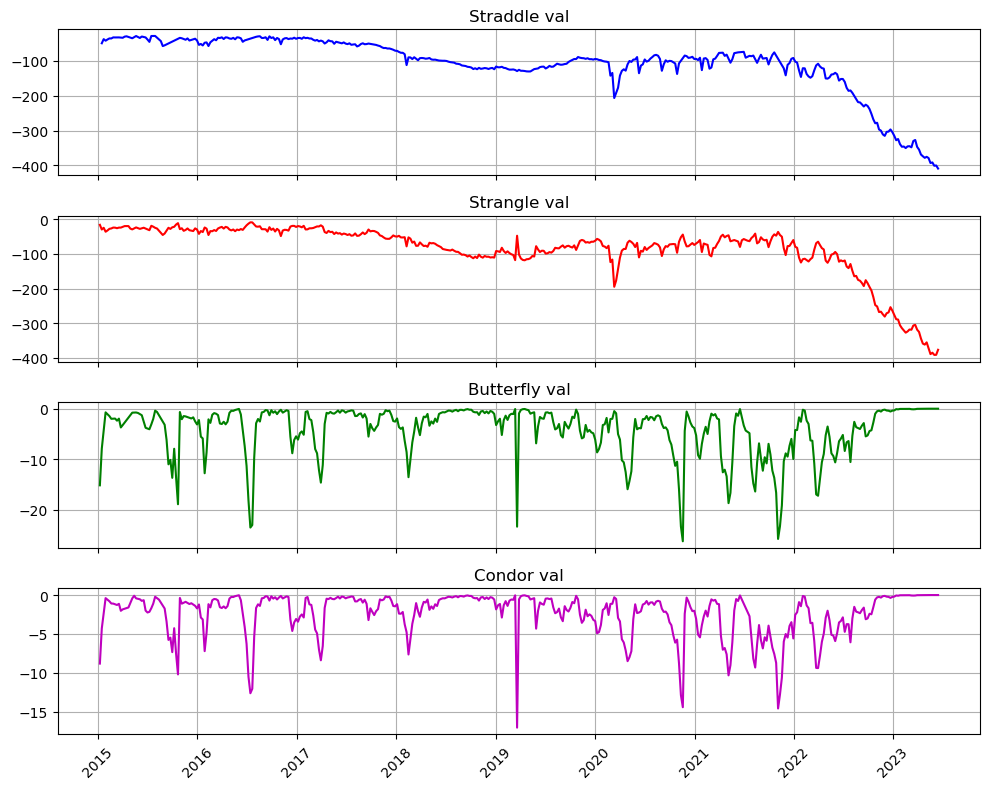

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot data for each strategy
axes[0].plot(straddle_dates, straddle_val, color='b', label='Straddle vaL')
axes[1].plot(strangle_dates, strangle_val, color='r', label='Strangle vaL')
axes[2].plot(butterfly_dates, butterfly_val, color='g', label='Butterfly vaL')
axes[3].plot(condor_dates, condor_val, color='m', label='Condor vaL')

# Add titles and legends
axes[0].set_title('Straddle val')
axes[1].set_title('Strangle val')
axes[2].set_title('Butterfly val')
axes[3].set_title('Condor val')

# Set grid to true
axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)
axes[3].grid(True)
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Adjust the layout
plt.tight_layout()
# Display the plot
plt.show()

<h3> 6.0 Saving Results </h4>

In [ ]:
def trade_history_to_df(val, pnl, dates):
    val_reshaped, pnl_reshaped, dates_reshaped = val.reshape(-1,1), pnl.reshape(-1,1), dates.reshape(-1,1)
    df = pd.DataFrame(np.hstack([val_reshaped, pnl_reshaped, dates_reshaped]), columns=['Value', 'PnL', 'Date'])
    df = df.set_index('Date')

    return df

# Generating df
straddle_df = trade_history_to_df(straddle_val, straddle_pnl,straddle_dates)
strangle_df = trade_history_to_df(strangle_val, strangle_pnl,strangle_dates)
butterfly_df = trade_history_to_df(butterfly_val, butterfly_pnl,butterfly_dates)
condor_df = trade_history_to_df(condor_val, condor_pnl, condor_dates)

# saving
SAVE_PATH = "results/"

straddle_df.to_csv(f"{SAVE_PATH}Straddle {FORECASTING_MODEL} {VOL_LOOKBACK} active_stop_lose.csv")
strangle_df.to_csv(f"{SAVE_PATH}Strangle {FORECASTING_MODEL} {VOL_LOOKBACK} active_stop_lose.csv")
butterfly_df.to_csv(f"{SAVE_PATH}Butterfly {FORECASTING_MODEL} {VOL_LOOKBACK} active_stop_lose.csv")
condor_df.to_csv(f"{SAVE_PATH}Condor {FORECASTING_MODEL} {VOL_LOOKBACK} active_stop_lose.cscv")